In [1]:
! pip install pyspark==3.3.2

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
import numpy as np
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName("ReadJSON").getOrCreate()
df = spark.read.json("/kaggle/input/fitrec-dataset/endomondoHR.json")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/08/28 15:21:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df.show()

+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+
|            altitude|gender|          heart_rate|       id|            latitude|           longitude|               speed|           sport|           timestamp|                 url|  userId|
+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+
|[41.6, 40.6, 40.6...|  male|[100, 111, 120, 1...|396826535|[60.1733487658202...|[24.6497704088687...|[6.8652, 16.4736,...|            bike|[1408898746, 1408...|https://www.endom...|10921915|
|[38.4, 39.0, 39.0...|  male|[100, 105, 111, 1...|392337038|[60.1732475962489...|[24.6498552337288...|[9.0792, 13.284, ...|            bike|[1408221682, 1408...|https://www.endom...|10921915|
|[76.4, 73.2, 72.4...|  male|[99, 105, 1

In [5]:
df.printSchema()

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)



In [6]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [7]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


In [8]:
print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

There are total 253020 row, Let print first 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


# Checking Missing Values for Each Column

In [9]:
from pyspark.sql.functions import col, sum


missing_values = df.select(
    *[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
)
missing_values.show()

+--------+------+----------+---+--------+---------+------+-----+---------+---+------+
|altitude|gender|heart_rate| id|latitude|longitude| speed|sport|timestamp|url|userId|
+--------+------+----------+---+--------+---------+------+-----+---------+---+------+
|       0|     0|         0|  0|       0|        0|203360|    0|        0|  0|     0|
+--------+------+----------+---+--------+---------+------+-----+---------+---+------+



In [10]:
from pyspark.sql import functions
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))

def summarize_user_activity_workout(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    total_records_count = format(df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()['sum(PerWorkoutRecordCount)'][0], ',d')
    
    columns = ['Users count', 'Activity types count', 'Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    summary_df = pd.DataFrame({columns[i]: data[i] for i in range(len(columns))})
    
    gender_user_count = df.select('gender', 'userId').distinct().groupBy('gender').count().toPandas()
    gender_activity_count = df.groupBy('gender').count().toPandas()
    gender_summary = gender_user_count.merge(
        gender_activity_count, on='gender', how='inner', suffixes=('_users', '_activities')
    )
    gender_summary.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return summary_df, gender_summary

result = summarize_user_activity_workout(df)
print('\nOverall data set summary on users, workouts and number of records (pre-filtering):')
result[0]



Overall data set summary on users, workouts and number of records (pre-filtering):


,Users count,Activity types count,Workouts count,Total records count
0,"1,104",49,"253,020","111,541,956"


In [11]:
rows = df.count()
columns = len(df.columns)
print(f"Dataset shape: ({rows}, {columns})")


Dataset shape: (253020, 12)


In [12]:
print('Number of workouts that have less than 50 records and statistic summary:')
removed_df = df.select('PerWorkoutRecordCount').where(df.PerWorkoutRecordCount < 50) \
               .toPandas().describe().astype(int)
removed_df.rename(columns = {'PerWorkoutRecordCount': 'PerWorkoutRecordCount <50'}, inplace=True)
removed_df.T

Number of workouts that have less than 50 records and statistic summary:


,count,mean,std,min,25%,50%,75%,max
PerWorkoutRecordCount <50,5541,23,14,1,11,22,36,49


# Top 5 workout types

In [13]:
ranked_sport_users_df = df.select(df.sport, df.userId) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy("count", ascending=False)
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()

In [14]:
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)


# Caculate the total users, we will this result to compute percentage later

In [15]:
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]
total_sports_users

3442

In [16]:
highest_sport_users_df

,sport,Users count
0,run,865
1,bike,794
2,mountain bike,336
3,bike (transport),252
4,walk,209


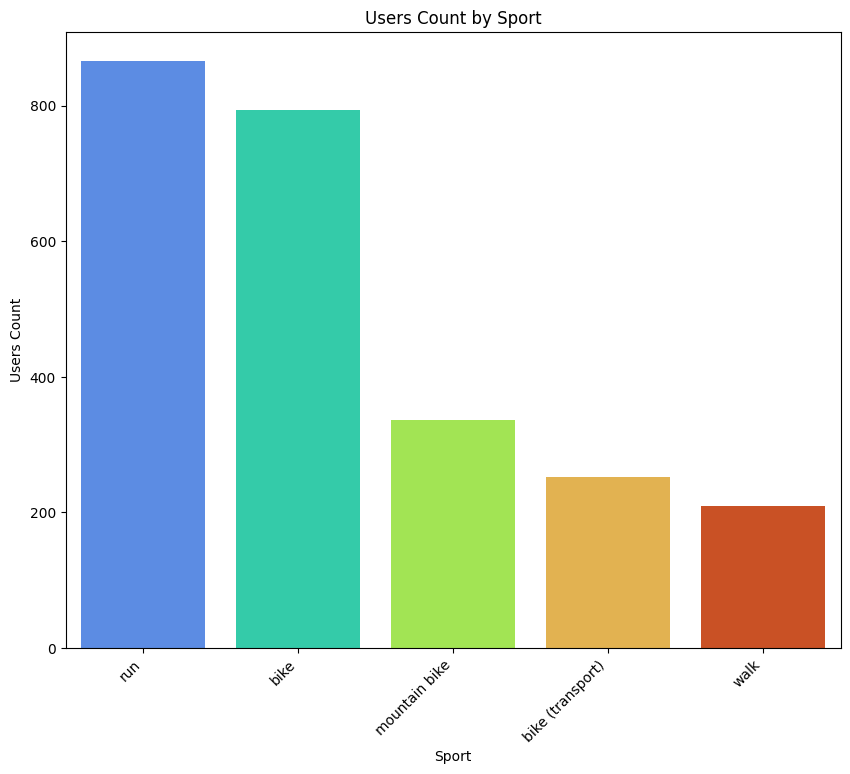

In [17]:
plt.figure(figsize=(10, 8))
sns.barplot(data=highest_sport_users_df, x='sport', y='Users count', palette='turbo')
plt.title('Users Count by Sport')
plt.xlabel('Sport')
plt.ylabel('Users Count')
plt.xticks(rotation=45, ha='right')
plt.show()

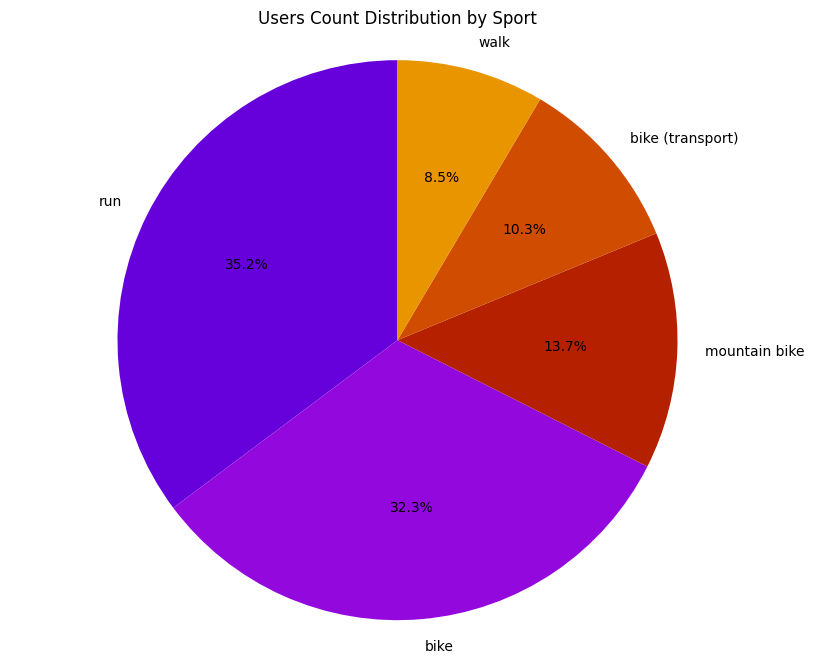

In [18]:
plt.figure(figsize=(10,8))
plt.pie(highest_sport_users_df['Users count'], labels=highest_sport_users_df['sport'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('gnuplot', len(highest_sport_users_df)))
plt.title('Users Count Distribution by Sport')
plt.axis("equal")
plt.show()

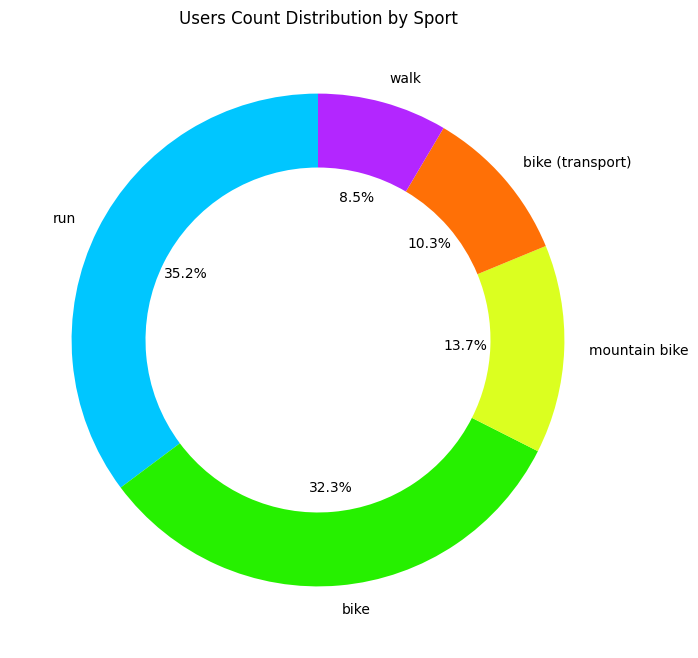

In [19]:
plt.figure(figsize=(10,8))
wedges, texts, autotexts = plt.pie(highest_sport_users_df['Users count'], 
                                   labels=highest_sport_users_df['sport'], 
                                   autopct='%1.1f%%', 
                                   startangle=90, 
                                   colors=sns.color_palette('gist_ncar', len(highest_sport_users_df)), 
                                   wedgeprops=dict(width=0.3))
plt.title('Users Count Distribution by Sport')
plt.show()

# activities by gender

In [20]:
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas() 
activities_by_gender[:5]

,sport,gender,count
0,hiking,female,71
1,core stability training,male,1103
2,run,male,107882
3,kayaking,male,253
4,mountain bike,male,12782


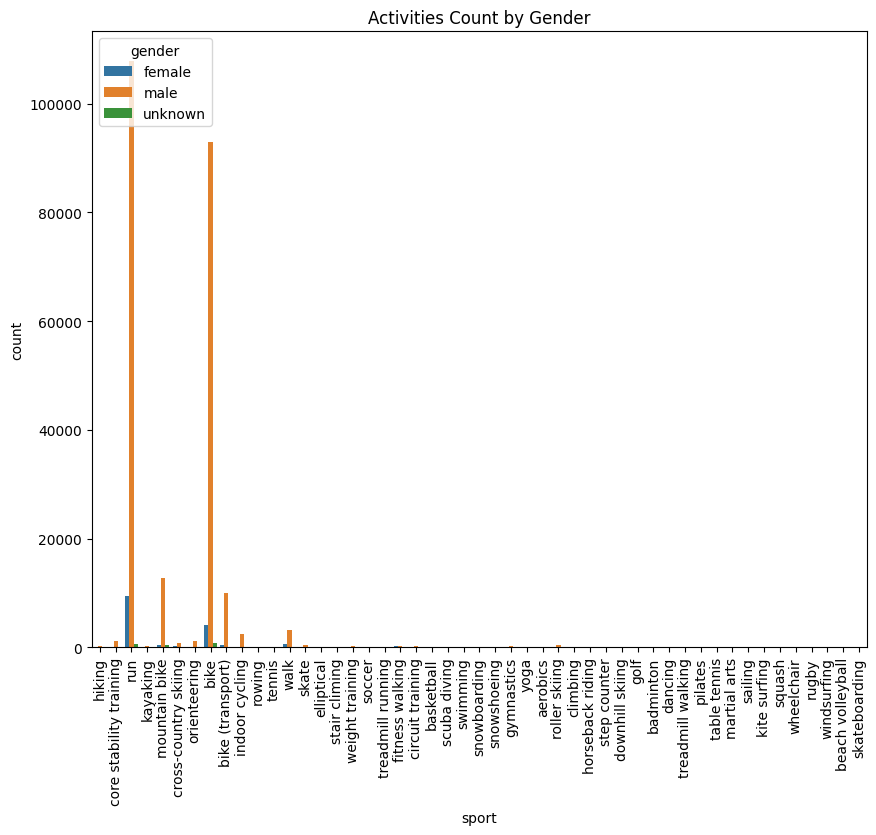

In [21]:
plt.figure(figsize=(10,8))
sns.barplot(x='sport', y='count', hue='gender', data=activities_by_gender)
plt.title('Activities Count by Gender')
plt.xticks(rotation=90)
plt.show()

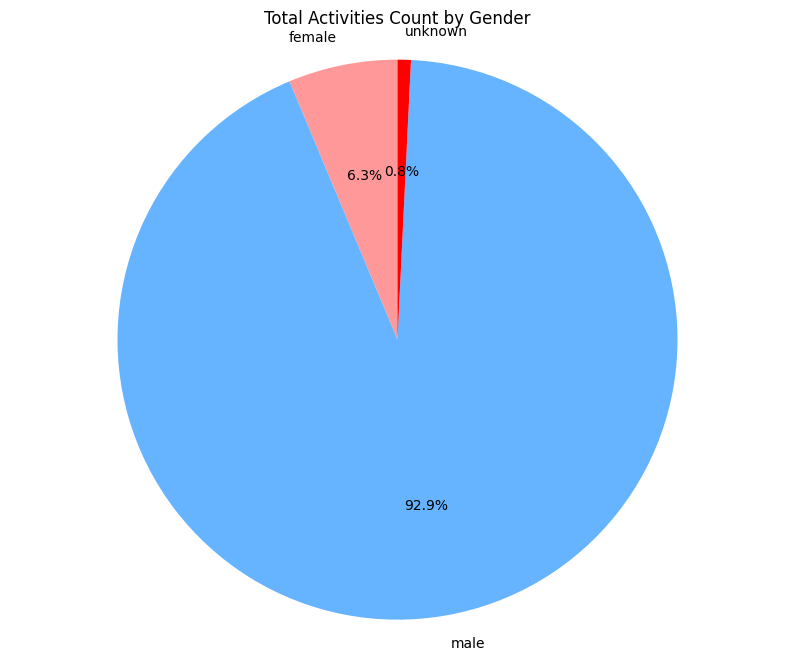

In [22]:
plt.figure(figsize=(10,8))
gender_counts = activities_by_gender.groupby('gender')['count'].sum()

plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff',"red"])
plt.title('Total Activities Count by Gender')
plt.axis("equal")
plt.show()


/tmp/ipykernel_4290/712517878.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  centre_circle = plt.Circle((0,0), 0.70, color='white', fc='white', edgecolor='white')


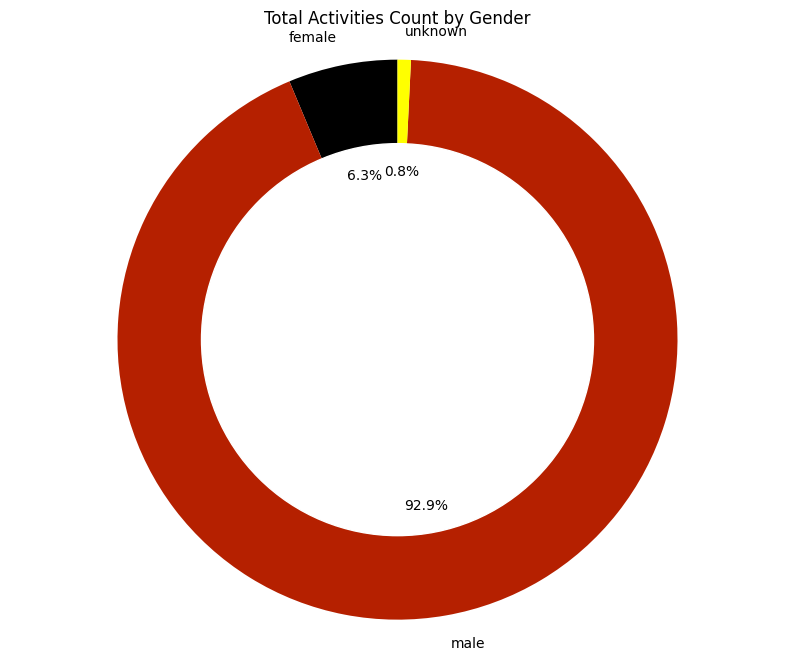

In [23]:


gender_counts = activities_by_gender.groupby('gender')['count'].sum()

fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.cm.gnuplot
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=cmap(np.linspace(0, 1, len(gender_counts))))

centre_circle = plt.Circle((0,0), 0.70, color='white', fc='white', edgecolor='white')
ax.add_artist(centre_circle)

plt.title('Total Activities Count by Gender')
plt.axis('equal')
plt.show()


In [24]:
activities_by_gender_pivot = activities_by_gender.pivot_table(index='sport', columns='gender', values='count', aggfunc='sum').reset_index()
activities_by_gender_pivot


gender,sport,female,male,unknown
0,aerobics,3.0,43.0,NaN
1,badminton,NaN,17.0,NaN
2,basketball,NaN,14.0,NaN
3,beach volleyball,NaN,2.0,NaN
4,bike,4172.0,92966.0,863.0
5,bike (transport),414.0,10030.0,1.0
6,circuit training,22.0,196.0,NaN
7,climbing,1.0,5.0,NaN
8,core stability training,143.0,1103.0,16.0
9,cross-country skiing,194.0,755.0,NaN


In [25]:
numeric_columns = activities_by_gender_pivot.select_dtypes(include=['float64', 'int64']).columns
activities_by_gender_pivot[numeric_columns] = activities_by_gender_pivot[numeric_columns].apply(lambda x: x.fillna(x.mean()), axis=0)
activities_by_gender_pivot.head()

gender,sport,female,male,unknown
0,aerobics,3.000000,43.0,161.833333
1,badminton,531.966667,17.0,161.833333
2,basketball,531.966667,14.0,161.833333
3,beach volleyball,531.966667,2.0,161.833333
4,bike,4172.000000,92966.0,863.000000


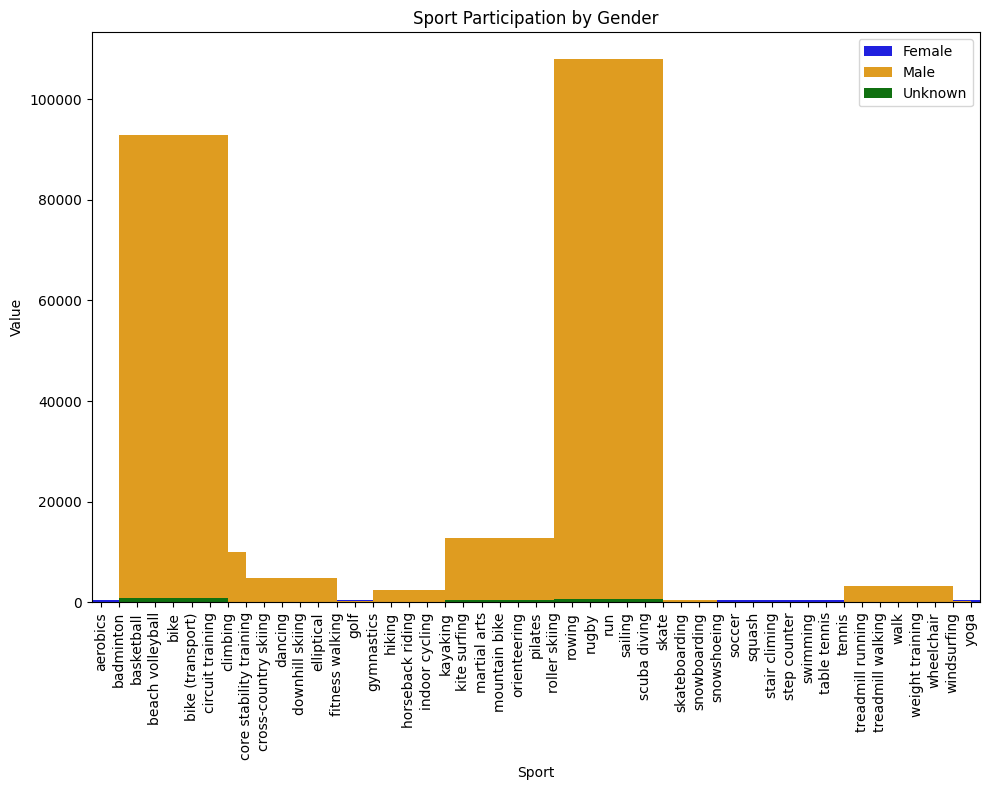

In [26]:
plt.figure(figsize=(10, 8))

sns.barplot(x='sport', y='female', data=activities_by_gender_pivot, color='blue', label='Female',width=6)
sns.barplot(x='sport', y='male', data=activities_by_gender_pivot, color='orange', label='Male',width=6)
sns.barplot(x='sport', y='unknown', data=activities_by_gender_pivot, color='green', label='Unknown',width=6)

plt.title('Sport Participation by Gender')
plt.xlabel('Sport')
plt.ylabel('Value')

plt.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
activities_by_gender_pivot["total"]= activities_by_gender_pivot[['female', 'male', 'unknown']].sum().sum()
activities_by_gender_pivot

gender,sport,female,male,unknown,total
0,aerobics,3.000000,43.0000,161.833333,274013.5125
1,badminton,531.966667,17.0000,161.833333,274013.5125
2,basketball,531.966667,14.0000,161.833333,274013.5125
3,beach volleyball,531.966667,2.0000,161.833333,274013.5125
4,bike,4172.000000,92966.0000,863.000000,274013.5125
5,bike (transport),414.000000,10030.0000,1.000000,274013.5125
6,circuit training,22.000000,196.0000,161.833333,274013.5125
7,climbing,1.000000,5.0000,161.833333,274013.5125
8,core stability training,143.000000,1103.0000,16.000000,274013.5125
9,cross-country skiing,194.000000,755.0000,161.833333,274013.5125


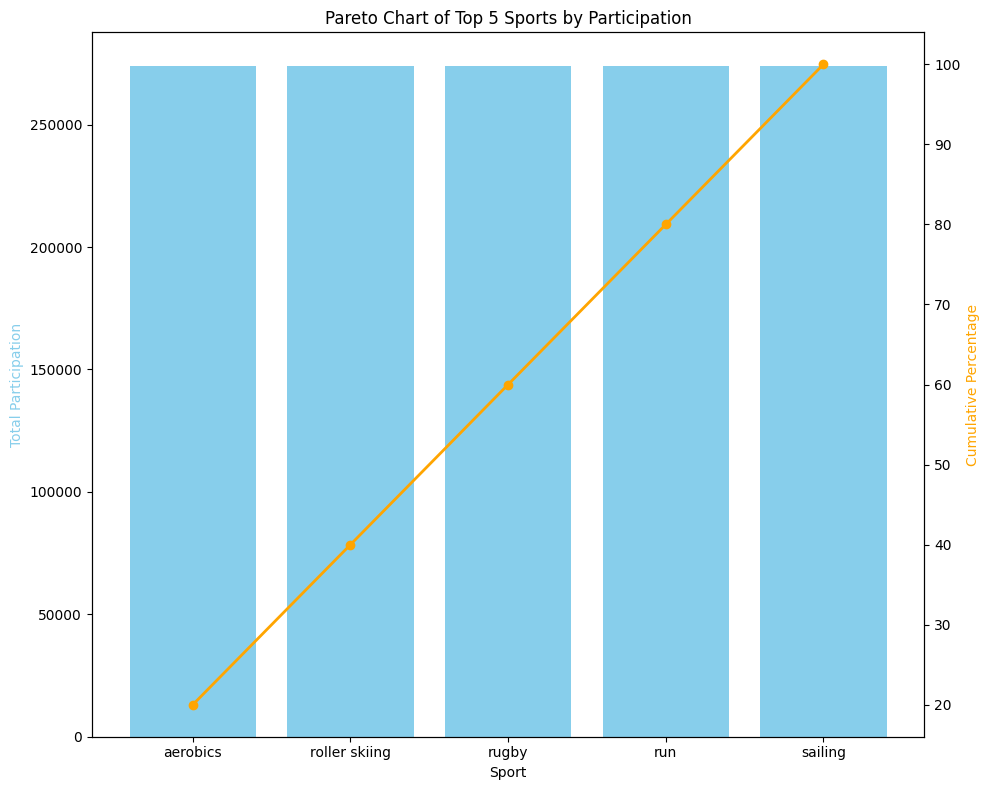

In [28]:


activities_by_gender_pivot = activities_by_gender_pivot.sort_values('total', ascending=False)

top_5_sports = activities_by_gender_pivot.head(5)

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(top_5_sports['sport'], top_5_sports['total'], color='skyblue')

cumulative_percentage = top_5_sports['total'].cumsum() / top_5_sports['total'].sum() * 100
ax2 = ax.twinx()
ax2.plot(top_5_sports['sport'], cumulative_percentage, color='orange', marker='o', linestyle='-', linewidth=2)

ax.set_xlabel('Sport')
ax.set_ylabel('Total Participation', color='skyblue')
ax2.set_ylabel('Cumulative Percentage', color='orange')
ax.set_title('Pareto Chart of Top 5 Sports by Participation')

plt.tight_layout()
plt.show()


In [29]:
top_5_sports

gender,sport,female,male,unknown,total
0,aerobics,3.000000,43.0,161.833333,274013.5125
25,roller skiing,6.000000,402.0,161.833333,274013.5125
27,rugby,531.966667,7.0,161.833333,274013.5125
28,run,9360.000000,107882.0,660.000000,274013.5125
29,sailing,531.966667,2.0,161.833333,274013.5125


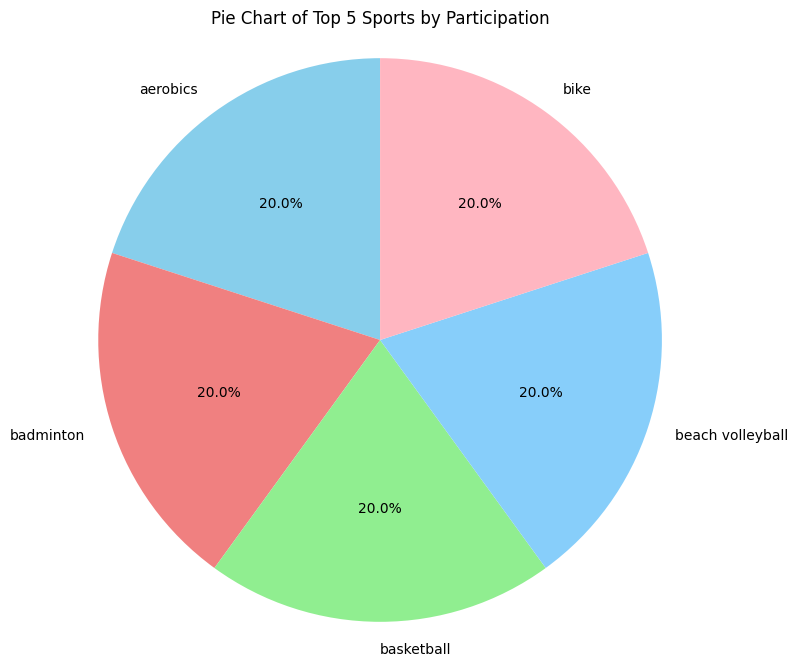

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

activities_by_gender_pivot = activities_by_gender_pivot.sort_values('total', ascending=False)

top_5_sports = activities_by_gender_pivot.head(5)

fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(top_5_sports['total'], labels=top_5_sports['sport'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightskyblue', 'lightpink'])

ax.set_title('Pie Chart of Top 5 Sports by Participation')

plt.axis('equal')
plt.show()


In [31]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.gender, df.sport) \
    .distinct() \
    .groupBy(df.userId, df.gender) \
    .count()    

user_more_sports_df = sport_df \
                    .filter(sport_df["count"] > min_number_of_sports) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)
user_more_sports_df.describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
userId,822,4860464,3953412,69,1609606,3730685,7554937,15481421
Sports count,822,3,2,2,2,3,5,16


In [32]:
user_more_sports_df.head()

,userId,gender,Sports count
0,8281868,male,16
1,5727574,male,13
2,2894897,male,13
3,331586,male,12
4,8276277,male,12


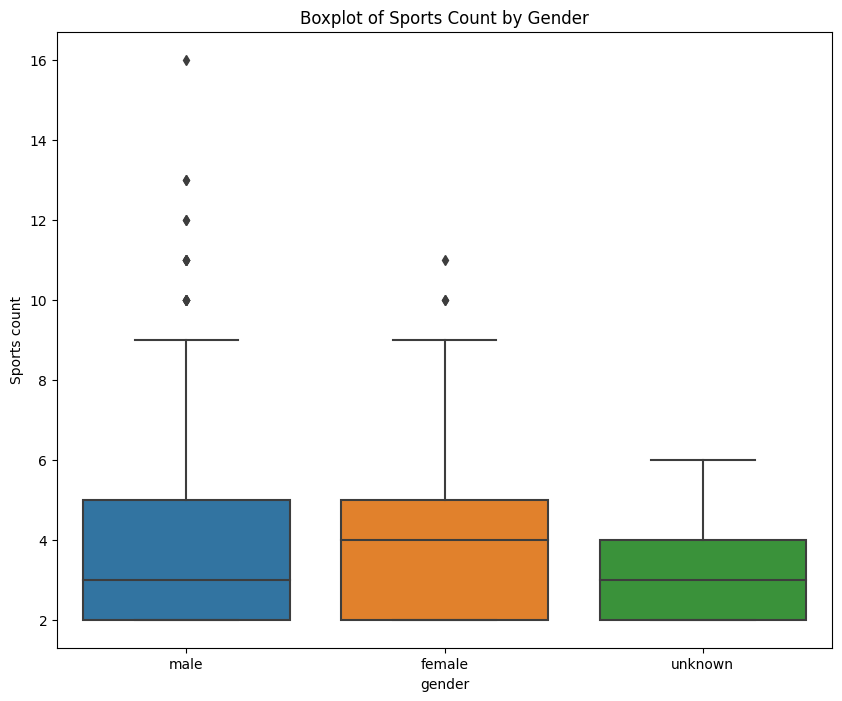

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(x='gender', y='Sports count', data=user_more_sports_df)
plt.title('Boxplot of Sports Count by Gender')
plt.show()

In [34]:
df.show()

+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+---------------------+
|            altitude|gender|          heart_rate|       id|            latitude|           longitude|               speed|           sport|           timestamp|                 url|  userId|PerWorkoutRecordCount|
+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+---------------------+
|[41.6, 40.6, 40.6...|  male|[100, 111, 120, 1...|396826535|[60.1733487658202...|[24.6497704088687...|[6.8652, 16.4736,...|            bike|[1408898746, 1408...|https://www.endom...|10921915|                  500|
|[38.4, 39.0, 39.0...|  male|[100, 105, 111, 1...|392337038|[60.1732475962489...|[24.6498552337288...|[9.0792, 13.284, ...|            bike|[140

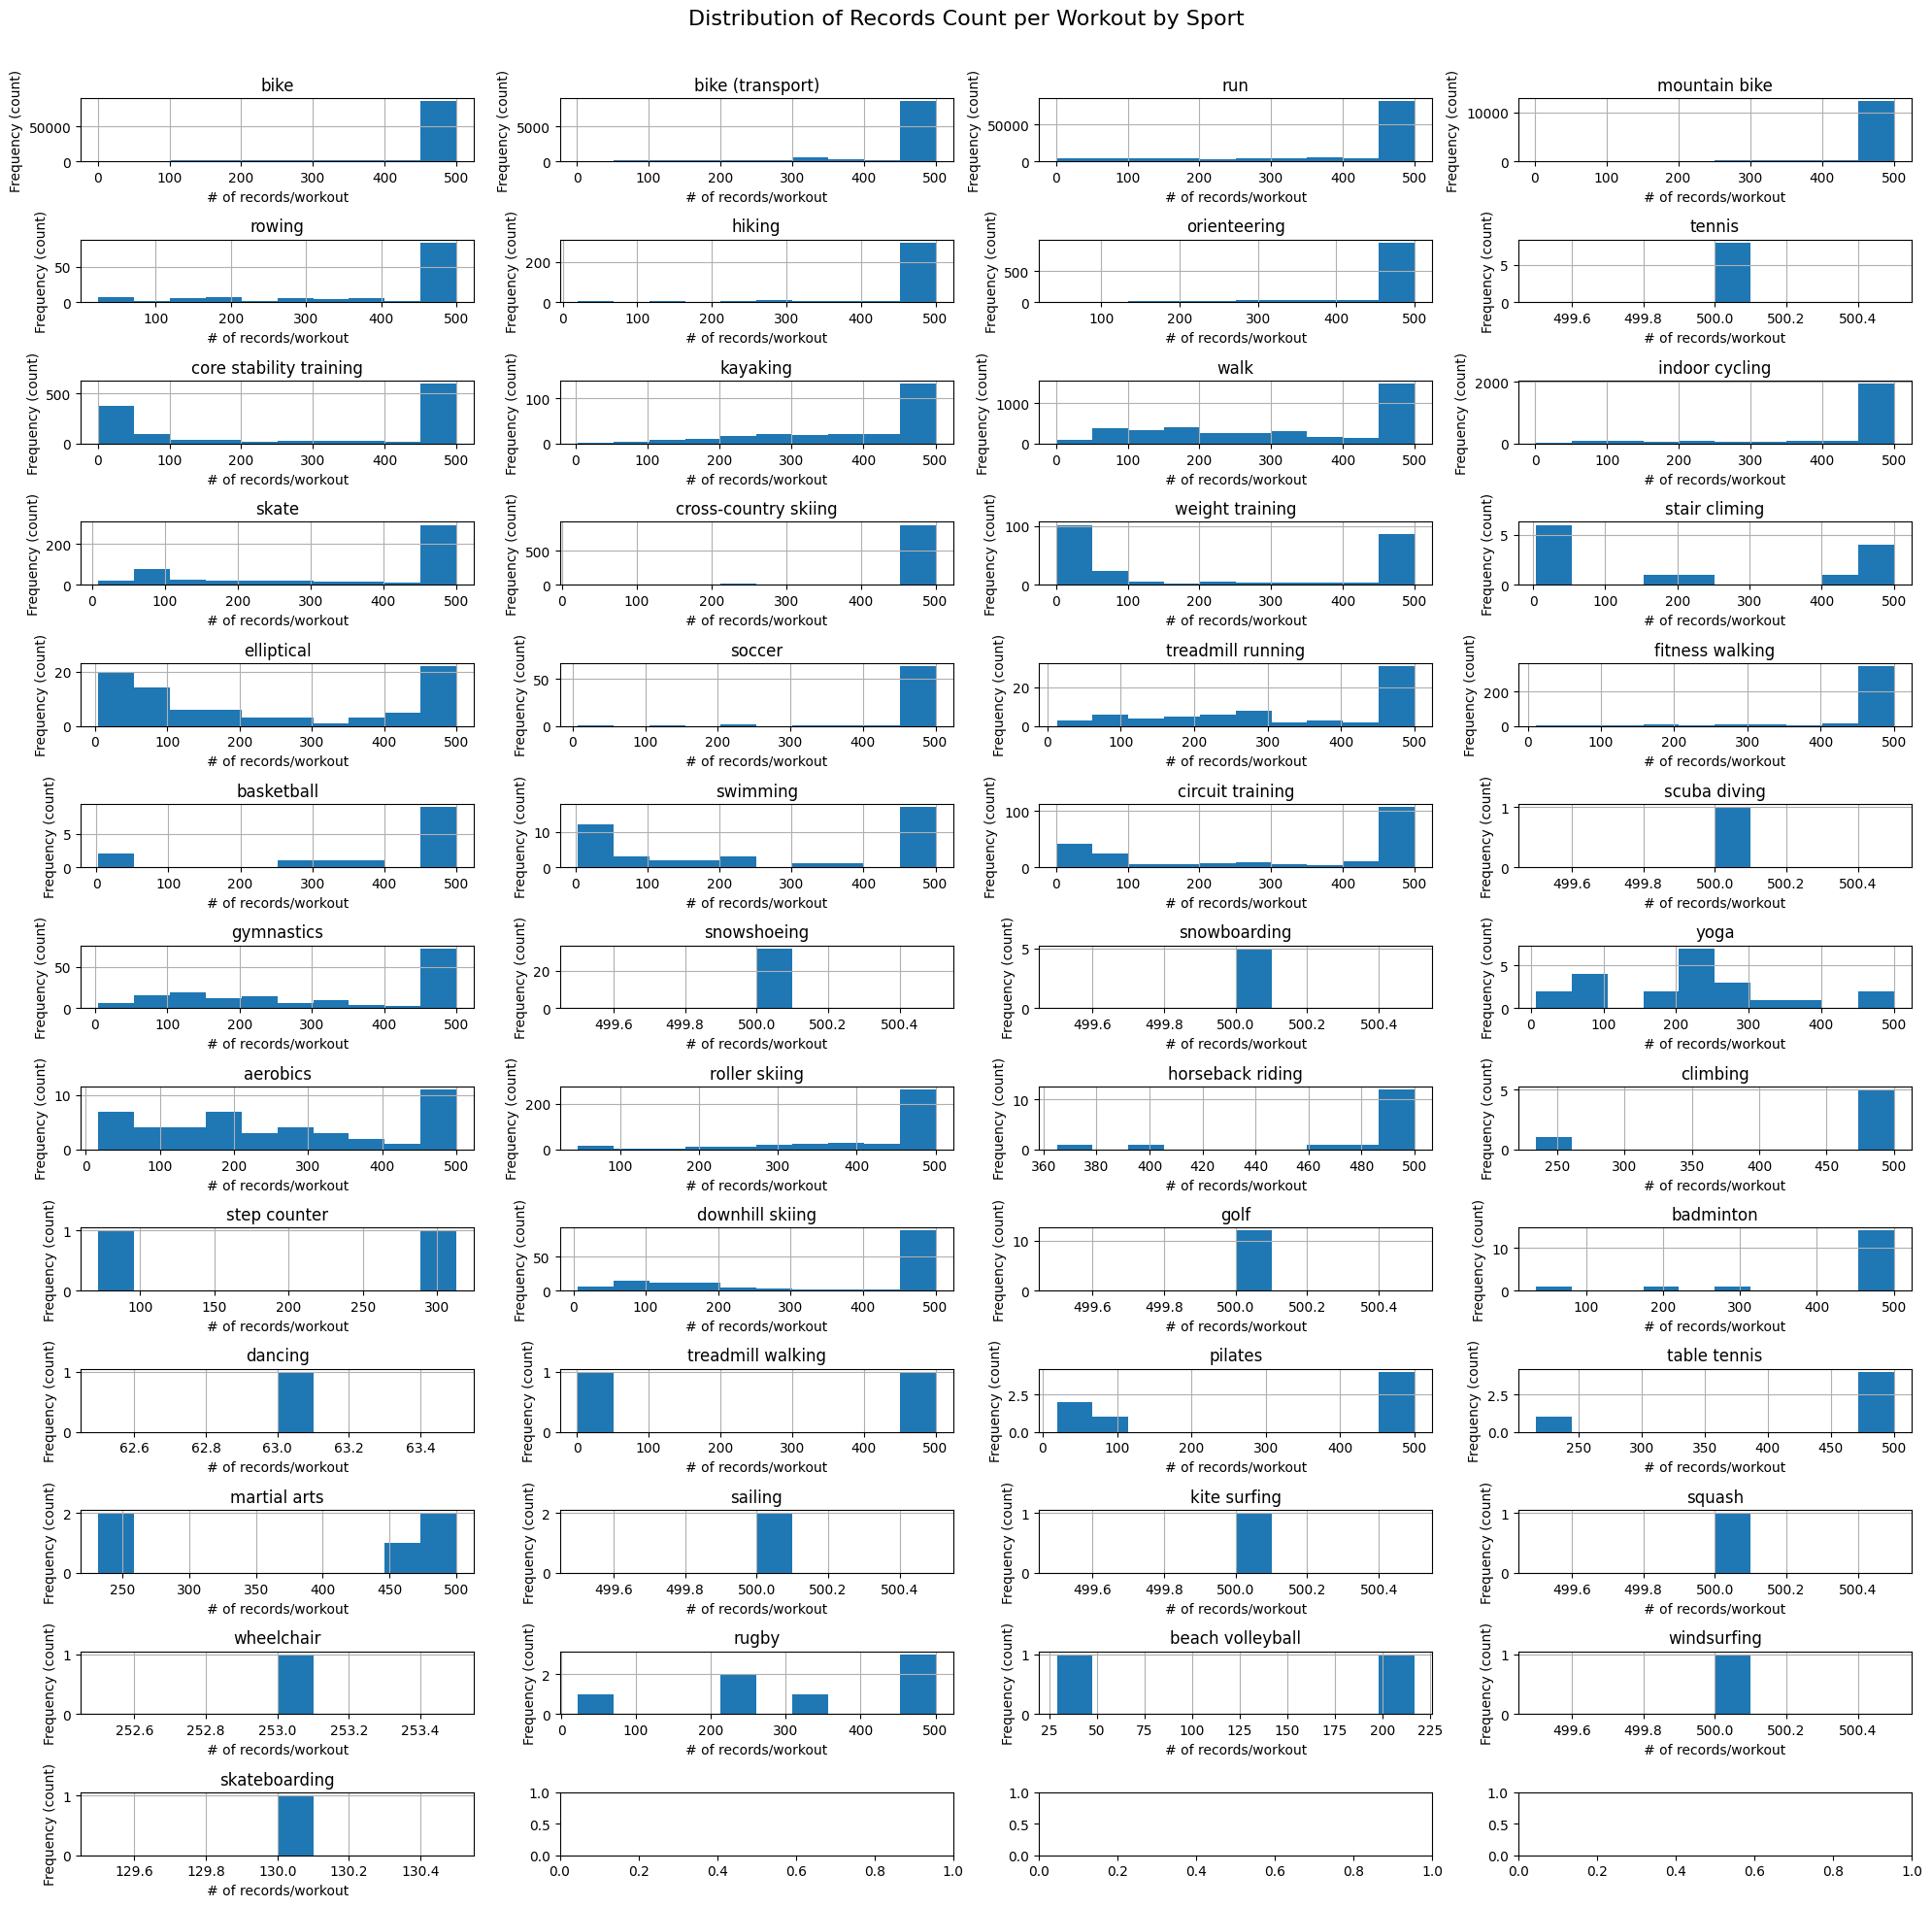

In [35]:


# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
df_pandas = df.select('PerWorkoutRecordCount', 'sport').toPandas()

# Set up figure size and layout
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 20))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Loop through unique sports and create a histogram for each
for idx, sport in enumerate(df_pandas['sport'].unique()):
    sport_data = df_pandas[df_pandas['sport'] == sport]
    sport_data['PerWorkoutRecordCount'].hist(bins=10, ax=axes[idx], grid=True)
    axes[idx].set_title(sport)
    axes[idx].set_xlabel('# of records/workout')
    axes[idx].set_ylabel('Frequency (count)')

# Add overall title and adjust layout
fig.suptitle('Distribution of Records Count per Workout by Sport', fontsize=16, ha='center')
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to make room for the title

plt.show()


In [36]:
qualified_df = df \
    .select(df.sport, df.userId, df.gender) \
    .groupBy(df.sport, df.userId, df.gender) \
    .count()
qualified_df = qualified_df.filter(qualified_df["count"] >= 10) \
    .orderBy("count", ascending = False)

In [37]:
qualified_df.show()

+----------------+--------+------+-----+
|           sport|  userId|gender|count|
+----------------+--------+------+-----+
|            bike| 3714939|  male| 2783|
|             run| 1063624|  male| 1874|
|             run| 1520156|  male| 1755|
|            bike|10821441|  male| 1666|
|             run| 2915343|  male| 1516|
|            bike|   65547|  male| 1221|
|bike (transport)| 2734298|  male| 1218|
|             run|  983950|  male| 1062|
|            bike| 9051351|  male| 1057|
|            bike|  804068|  male| 1033|
|            bike| 3347250|  male| 1015|
|             run| 2461936|  male| 1005|
|            bike|  846598|  male|  991|
|             run|  860533|  male|  988|
|            bike| 4535678|  male|  923|
|            bike|  538524|  male|  904|
|            bike|  797841|  male|  879|
|             run| 2474825|  male|  877|
|             run| 7516129|  male|  864|
|bike (transport)| 4997910|  male|  856|
+----------------+--------+------+-----+
only showing top

In [38]:
# Print the number of users having more than 10 workouts
qualified_pd_df = qualified_df.select("userId", "gender").distinct() \
    .groupBy(qualified_df.gender).count().toPandas()

# Rename columns for clarity
qualified_pd_df.rename(columns={'count': 'Users count'}, inplace=True)

# Sum the 'Users count' column correctly using Pandas
qualified_users_count = qualified_pd_df['Users count'].sum()

# Get the total number of distinct users
total_users_count = df.select('userId').distinct().count()

# Calculate the percentage of qualified users
qualified_percentage = round((qualified_users_count / total_users_count), 2) * 100

# Output the results
print('\nSo there are {} / {} of users qualifying the 10 historical records criteria, which is {:.2f}%'.format(
    qualified_users_count, total_users_count, qualified_percentage)
)



So there are 987 / 1104 of users qualifying the 10 historical records criteria, which is 89.00%


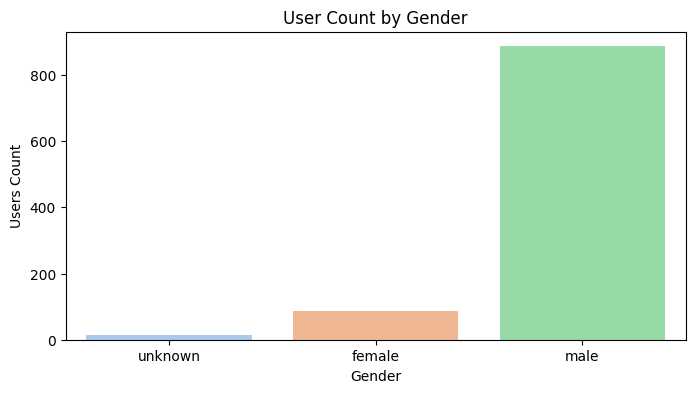

In [39]:
qualified_pd_df

data = pd.DataFrame(qualified_pd_df)

# Seaborn bar plot
plt.figure(figsize=(8,4))
sns.barplot(x="gender", y="Users count", data=data, palette="pastel")
plt.title("User Count by Gender")
plt.ylabel("Users Count")
plt.xlabel("Gender")
plt.show()

In [40]:
pdf = df.limit(5).toPandas()
pdf

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500
3,"[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,"[60.173286236822605, 60.17323946580291, 60.173...","[24.649874344468117, 24.650242729112506, 24.65...","[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...",bike,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915,500
4,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,"[60.17329327762127, 60.17327332869172, 60.1732...","[24.64979832060635, 24.64992195367813, 24.6500...",None,bike (transport),"[1406909434, 1406909436, 1406909437, 140690943...",https://www.endomondo.com/users/10921915/worko...,10921915,500


In [41]:
spark = SparkSession.builder.appName("WorkoutAnalysis").getOrCreate()

25/08/28 15:31:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode_outer, from_json, when, to_timestamp
from pyspark.sql.types import ArrayType, FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.sql.functions import col, when, array, size
from pyspark.sql.functions import arrays_zip, explode_outer

In [43]:
df.show()

+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+---------------------+
|            altitude|gender|          heart_rate|       id|            latitude|           longitude|               speed|           sport|           timestamp|                 url|  userId|PerWorkoutRecordCount|
+--------------------+------+--------------------+---------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------+---------------------+
|[41.6, 40.6, 40.6...|  male|[100, 111, 120, 1...|396826535|[60.1733487658202...|[24.6497704088687...|[6.8652, 16.4736,...|            bike|[1408898746, 1408...|https://www.endom...|10921915|                  500|
|[38.4, 39.0, 39.0...|  male|[100, 105, 111, 1...|392337038|[60.1732475962489...|[24.6498552337288...|[9.0792, 13.284, ...|            bike|[140

In [46]:
from pyspark.sql.functions import col, arrays_zip, explode_outer, to_timestamp
import matplotlib.pyplot as plt

# Zip arrays together and explode
df_zipped = df.withColumn("zipped", arrays_zip(
    "altitude", "heart_rate", "latitude", "longitude", "speed", "timestamp"
))
flattened_df = df_zipped.withColumn("exploded", explode_outer("zipped"))

flattened_df = flattened_df.select(
    "id", "gender", "sport", "userId", "PerWorkoutRecordCount", "url",
    col("exploded.altitude").alias("altitude"),
    col("exploded.heart_rate").alias("heart_rate"),
    col("exploded.latitude").alias("latitude"),
    col("exploded.longitude").alias("longitude"),
    col("exploded.speed").alias("speed"),
    col("exploded.timestamp").alias("datetime")  # rename for convenience
)

# Drop the original timestamp column if it's causing issues
flattened_df = flattened_df.drop("datetime")  # Drop the column entirely

# Convert to Pandas
pandas_df = flattened_df.limit(5000).toPandas()


In [47]:
pandas_df.head()

,id,gender,sport,userId,PerWorkoutRecordCount,url,altitude,heart_rate,latitude,longitude,speed
0,396826535,male,bike,10921915,500,https://www.endomondo.com/users/10921915/worko...,41.6,100.0,60.173349,24.649770,6.8652
1,396826535,male,bike,10921915,500,https://www.endomondo.com/users/10921915/worko...,40.6,111.0,60.173240,24.650143,16.4736
2,396826535,male,bike,10921915,500,https://www.endomondo.com/users/10921915/worko...,40.6,120.0,60.172980,24.650911,19.1988
3,396826535,male,bike,10921915,500,https://www.endomondo.com/users/10921915/worko...,38.4,119.0,60.172478,24.650669,20.4804
4,396826535,male,bike,10921915,500,https://www.endomondo.com/users/10921915/worko...,37.0,120.0,60.171861,24.649145,31.3956


In [49]:
pandas_df['speed_kmh'] = pandas_df['speed'] * 3.6  

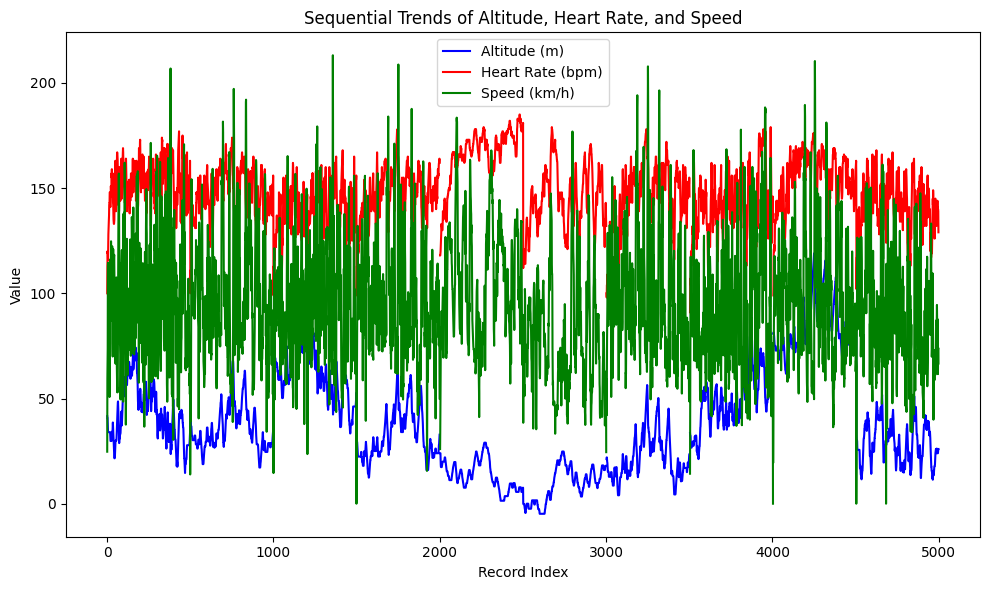

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df.index, pandas_df['altitude'], label='Altitude (m)', color='blue')
plt.plot(pandas_df.index, pandas_df['heart_rate'], label='Heart Rate (bpm)', color='red')
plt.plot(pandas_df.index, pandas_df['speed_kmh'], label='Speed (km/h)', color='green')
plt.xlabel('Record Index')
plt.ylabel('Value')
plt.title('Sequential Trends of Altitude, Heart Rate, and Speed')
plt.legend()
plt.tight_layout()
plt.show()

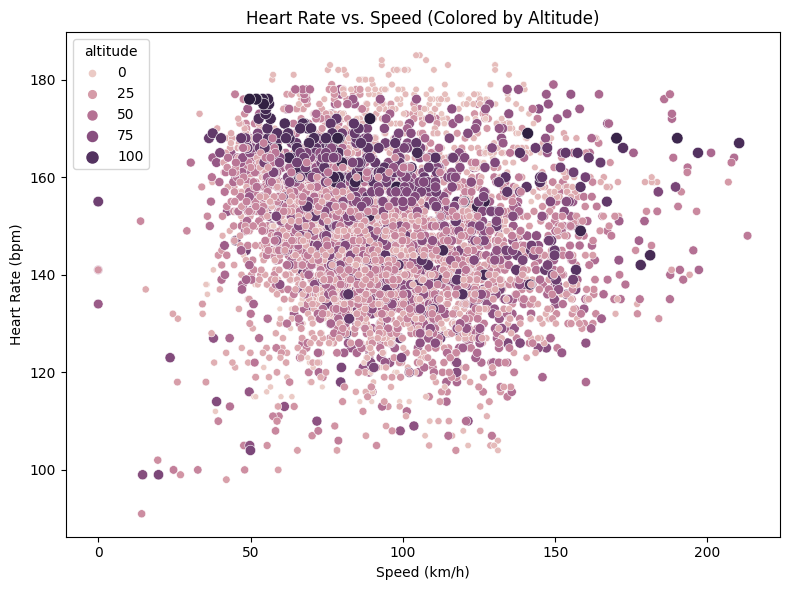

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_df, x='speed_kmh', y='heart_rate', hue='altitude', size='altitude')
plt.xlabel('Speed (km/h)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate vs. Speed (Colored by Altitude)')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


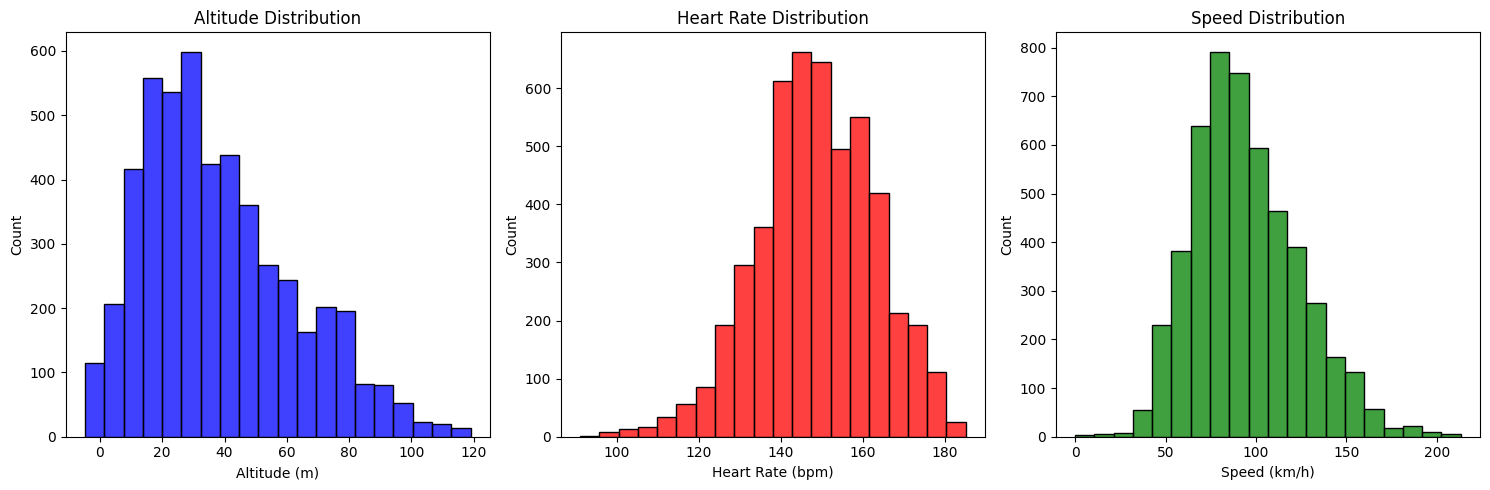

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(pandas_df['altitude'], bins=20, ax=axes[0], color='blue')
axes[0].set_title('Altitude Distribution')
axes[0].set_xlabel('Altitude (m)')
sns.histplot(pandas_df['heart_rate'], bins=20, ax=axes[1], color='red')
axes[1].set_title('Heart Rate Distribution')
axes[1].set_xlabel('Heart Rate (bpm)')
sns.histplot(pandas_df['speed_kmh'], bins=20, ax=axes[2], color='green')
axes[2].set_title('Speed Distribution')
axes[2].set_xlabel('Speed (km/h)')
plt.tight_layout()
plt.show()

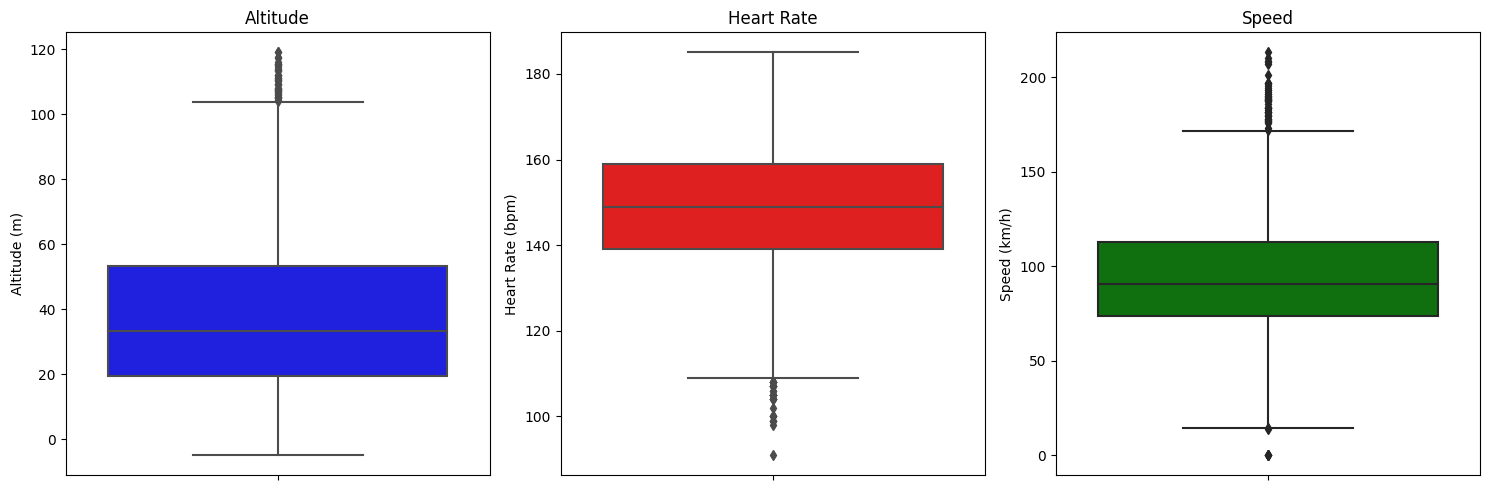

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=pandas_df['altitude'], ax=axes[0], color='blue')
axes[0].set_title('Altitude')
axes[0].set_ylabel('Altitude (m)')
sns.boxplot(y=pandas_df['heart_rate'], ax=axes[1], color='red')
axes[1].set_title('Heart Rate')
axes[1].set_ylabel('Heart Rate (bpm)')
sns.boxplot(y=pandas_df['speed_kmh'], ax=axes[2], color='green')
axes[2].set_title('Speed')
axes[2].set_ylabel('Speed (km/h)')
plt.tight_layout()
plt.show()

In [65]:
import folium

# Drop rows with NaN in latitude or longitude
pandas_df_clean = pandas_df.dropna(subset=['latitude', 'longitude'])

# Create a Folium map centered on the mean latitude and longitude
m = folium.Map(
    location=[pandas_df_clean['latitude'].mean(), pandas_df_clean['longitude'].mean()],
    zoom_start=15
)

# Add polyline for the route
folium.PolyLine(
    pandas_df_clean[['latitude', 'longitude']].values.tolist(),  # convert to list
    color='blue',
    weight=5
).add_to(m)

# Add markers for start and end points
folium.Marker(
    location=[pandas_df_clean['latitude'].iloc[0], pandas_df_clean['longitude'].iloc[0]],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    location=[pandas_df_clean['latitude'].iloc[-1], pandas_df_clean['longitude'].iloc[-1]],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# Save map to HTML
m.save('bike_route.html')

# In Jupyter, display
m


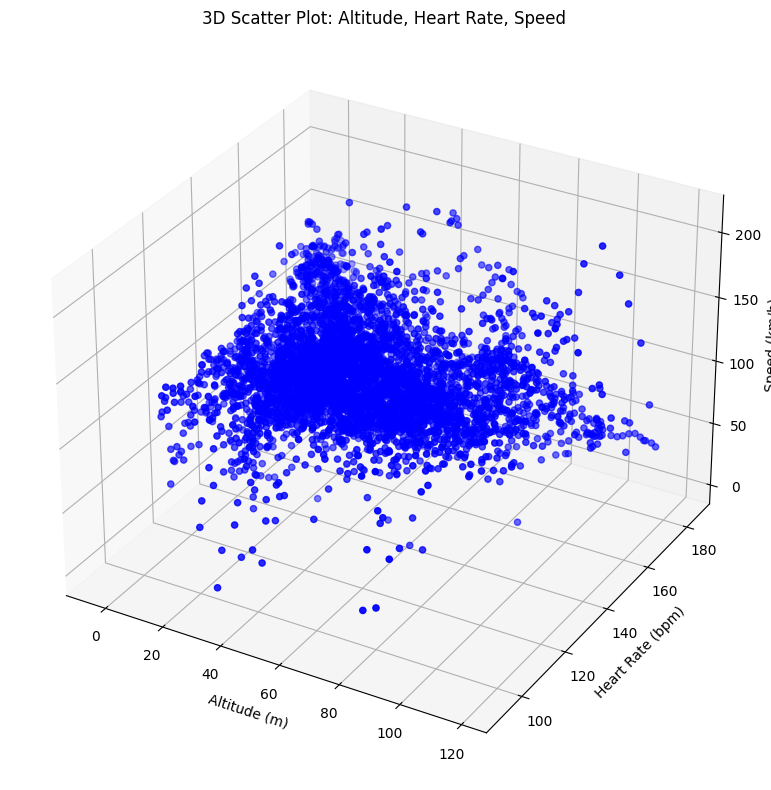

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pandas_df['altitude'], pandas_df['heart_rate'], pandas_df['speed_kmh'], c='blue', marker='o')
ax.set_xlabel('Altitude (m)')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_zlabel('Speed (km/h)')
plt.title('3D Scatter Plot: Altitude, Heart Rate, Speed')
plt.tight_layout()
plt.show()

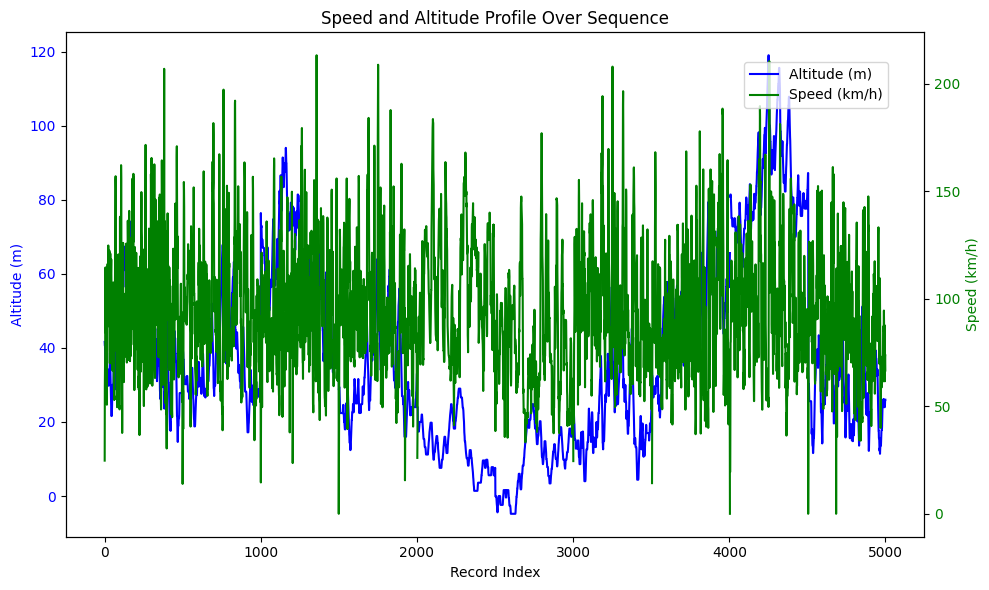

In [57]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot altitude
ax1.plot(pandas_df.index, pandas_df['altitude'], color='blue', label='Altitude (m)')
ax1.set_xlabel('Record Index')
ax1.set_ylabel('Altitude (m)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for speed
ax2 = ax1.twinx()
ax2.plot(pandas_df.index, pandas_df['speed_kmh'], color='green', label='Speed (km/h)')
ax2.set_ylabel('Speed (km/h)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Speed and Altitude Profile Over Sequence')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()